In [1]:
import numpy as np
import pandas as pd
import librosa
import time
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import Networks

Only fully connected layer regularized

In [2]:
# Load saved segments
def Load_Segments(dataset, fold):
    
    if dataset=='ESC10':
        if fold==1:
            hf = h5py.File('ESC10/MF1.h5', 'r')    
        if fold==2:
            hf = h5py.File('ESC10/MF2.h5', 'r')
        if fold==3:
            hf = h5py.File('ESC10/MF3.h5', 'r')
        if fold==4:
            hf = h5py.File('ESC10/MF4.h5', 'r')
        if fold==5:
            hf = h5py.File('ESC10/MF5.h5', 'r')

    if dataset=='ESC50':
        if fold==1:
            hf = h5py.File('ESC50/MF1.h5', 'r')    
        if fold==2:
            hf = h5py.File('ESC50/MF2.h5', 'r')
        if fold==3:
            hf = h5py.File('ESC50/MF3.h5', 'r')
        if fold==4:
            hf = h5py.File('ESC50/MF4.h5', 'r')
        if fold==5:
            hf = h5py.File('ESC50/MF5.h5', 'r')
    
    # Get training
    train_d = np.array(hf.get('train_data'))
    train_l = np.array(hf.get('train_label'))


    # Get validation
    val_d = np.array(hf.get('validation_data'))
    val_l = np.array(hf.get('validation_label'))

    # Get test
    test_d = np.array(hf.get('test_label'))
    test_l = np.array(hf.get('test_label'))

    hf.close()
    
    # Cast to float32
    train_d = np.asarray(train_d, dtype=np.float32)
    train_l = np.asarray(train_l, dtype=np.float32)
    
    val_d = np.asarray(val_d, dtype=np.float32)
    val_l = np.asarray(val_l, dtype=np.float32)
    
    test_d = np.asarray(test_d, dtype=np.float32)
    test_l = np.asarray(test_l, dtype=np.float32)
    
    return train_d, train_l, val_d, val_l, test_d, test_l


def CreateTrainingSet10(data, label, batch_size=32):
    
    # Shuffle the folds
    rnd_indices = np.arange(0, len(data))
    rnd_indices = np.random.shuffle(rnd_indices)
    
    data = data[rnd_indices].reshape((len(data), 60, 41, 3))
    label = label[rnd_indices].reshape((len(label), 10))
    
    
    data = data.astype(np.float32)
    label = label.astype(np.float32)
    
    '''
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0,
                                                              height_shift_range=0,
                                                              horizontal_flip=False,
                                                              vertical_flip=False) 
    
    # Shuffle all elements at every iteration
    training_dataset = datagen.flow(data, label, batch_size=batch_size, shuffle=True)
    '''
    
    training_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Shuffle all elements at every iteration
    training_dataset = training_dataset.shuffle(len(training_dataset))
    
    # Define batch_size and prefetch size
    training_dataset = training_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return training_dataset


def CreateTrainingSet50(data, label, batch_size=32):
    
    # Shuffle the folds
    rnd_indices = np.arange(0, len(data))
    rnd_indices = np.random.shuffle(rnd_indices)
    
    data = data[rnd_indices].reshape((len(data), 60, 41, 3))
    label = label[rnd_indices].reshape((len(label), 50))
    
    
    data = data.astype(np.float32)
    label = label.astype(np.float32)
    
    '''
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0,
                                                              height_shift_range=0,
                                                              horizontal_flip=False,
                                                              vertical_flip=False) 
    
    # Shuffle all elements at every iteration
    training_dataset = datagen.flow(data, label, batch_size=batch_size, shuffle=True)
    '''
    
    training_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Shuffle all elements at every iteration
    training_dataset = training_dataset.shuffle(len(training_dataset))
    
    # Define batch_size and prefetch size
    training_dataset = training_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return training_dataset


def CreateValidationSet(data, label, batch_size=32):
    
    data = data.astype(dtype=np.float32)
    label = label.astype(dtype=np.float32)
    
    # Create and cache training
    validation_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Cache dataset
    #validation_dataset = validation_dataset.cache(name)
    
    # Define batch_size and prefetch size
    validation_dataset = validation_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return validation_dataset

In [3]:
batch_size=256
max_epochs=100

train_d, train_l, val_d, val_l, test_d, test_l = Load_Segments('ESC10', 1)

training_dataset = CreateTrainingSet10(train_d, train_l, batch_size=batch_size)
validation_dataset = CreateValidationSet(val_d, val_l, batch_size=batch_size)
    
# Initialize the network
net = Networks.MFNetReg10([60, 41, 3])
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(lr=0.002, momentum=0.9, nesterov=True)
net.compile(optimizer=opt, loss=loss_f, metrics=["accuracy"])

In [4]:
epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):


    step_loss = []
    step_acc = []

    step_vl = []
    step_va = []

    batches = 0
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:

        # train on batch
        step_stats = net.train_on_batch(x_batch, y_batch)

        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])


    # compute validation stats
    for x_batch, y_batch in validation_dataset:

        # compute validation stats
        val_stats = net.test_on_batch(x_batch, y_batch)

        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])


    end = time.time()

    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))

    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))


Epoch  1: 	 t-loss: 2.037357 	 t-acc: 0.336528 	 v-loss: 2.289184 	 v-acc: 0.164419 	 time: 8.164
Epoch  2: 	 t-loss: 1.253884 	 t-acc: 0.569896 	 v-loss: 2.292473 	 v-acc: 0.065850 	 time: 3.766
Epoch  3: 	 t-loss: 0.965915 	 t-acc: 0.665337 	 v-loss: 2.290551 	 v-acc: 0.122656 	 time: 3.788
Epoch  4: 	 t-loss: 0.785982 	 t-acc: 0.724008 	 v-loss: 2.300488 	 v-acc: 0.124219 	 time: 3.780
Epoch  5: 	 t-loss: 0.643677 	 t-acc: 0.785668 	 v-loss: 2.305661 	 v-acc: 0.130469 	 time: 3.758
Epoch  6: 	 t-loss: 0.541582 	 t-acc: 0.809887 	 v-loss: 2.320078 	 v-acc: 0.112500 	 time: 3.791
Epoch  7: 	 t-loss: 0.467602 	 t-acc: 0.842931 	 v-loss: 2.323718 	 v-acc: 0.132812 	 time: 3.754
Epoch  8: 	 t-loss: 0.415213 	 t-acc: 0.860636 	 v-loss: 2.334827 	 v-acc: 0.160156 	 time: 3.742
Epoch  9: 	 t-loss: 0.360196 	 t-acc: 0.879305 	 v-loss: 2.374879 	 v-acc: 0.162500 	 time: 3.838
Epoch 10: 	 t-loss: 0.325519 	 t-acc: 0.892718 	 v-loss: 2.344322 	 v-acc: 0.121094 	 time: 3.746
Epoch 11: 	 t-loss: 

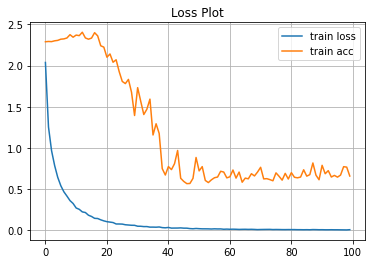

In [5]:
plt.figure()
plt.plot(epoch_loss, label='train loss')
plt.plot(epoch_vl, label='train acc')
plt.grid()
plt.legend()
plt.title('Loss Plot')
plt.show()

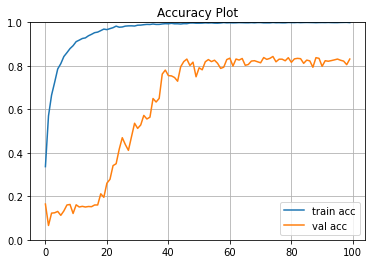

In [6]:
plt.figure()
plt.plot(epoch_acc, label='train acc')
plt.plot(epoch_va, label='val acc')
plt.grid()
plt.legend()
plt.ylim(0, 1)
plt.title('Accuracy Plot')
plt.show()